<a href="https://colab.research.google.com/github/CyberMaryVer/detectron-doc/blob/master/MeTRAbs_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MeTRAbs Absolute 3D Human Pose Estimator

István Sárándi, Timm Linder, Kai Oliver Arras, Bastian Leibe: "*MeTRAbs: Metric-Scale Truncation-Robust Heatmaps for Absolute 3D Human Pose Estimation.*"
In IEEE Transactions on Biometrics, Behavior, and Identity Science (T-BIOM), Selected Best Works From Automatic Face and Gesture Recognition (FG) 2020

* https://github.com/isarandi/metrabs
* https://arxiv.org/abs/2007.07227
* https://youtu.be/BemM8-Lx47g

Let's get the model files and a test image.

In [ ]:
%%shell
wget -q https://omnomnom.vision.rwth-aachen.de/data/metrabs/metrabs_{multiperson_smpl,multiperson_smpl_combined}.zip -P models
unzip -q 'models/*.zip' -d models
wget -q https://raw.githubusercontent.com/isarandi/metrabs/master/test_image_3dpw.jpg


2 archives were successfully processed.


## Combined Detector + Pose Estimator
Load the combined detector+pose estimator model and run it on the test image. (Detector credits: https://github.com/hunglc007/tensorflow-yolov4-tflite)

In [ ]:
import tensorflow as tf
model = tf.saved_model.load('models/metrabs_multiperson_smpl_combined')
image = tf.image.decode_jpeg(tf.io.read_file('test_image_3dpw.jpg'))
detections, poses3d, poses2d = model.predict_single_image(image)

In [ ]:
!wget https://sarajevo.travel/assets/photos/events/original/balkan-health-amp-fitness-summit-1540381827.jpg -q -O input.jpg
image = tf.image.decode_jpeg(tf.io.read_file('input.jpg'))
detections, poses3d, poses2d = model.predict_single_image(image)

## Visualize

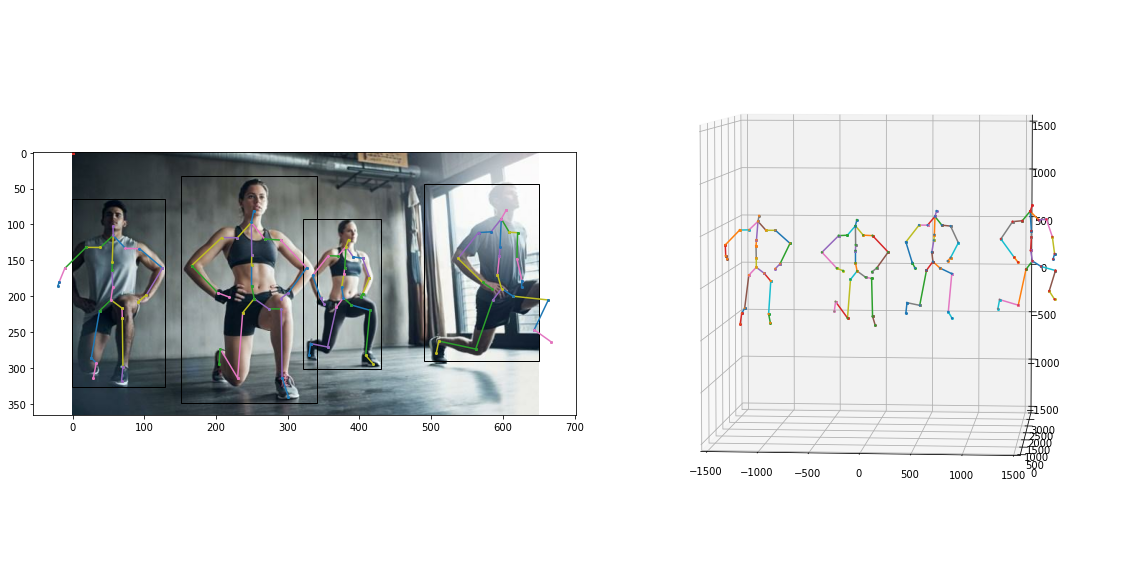

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D

def visualize(im, detections, poses3d, poses2d, edges):
    fig = plt.figure(figsize=(16, 8))
    image_ax = fig.add_subplot(1, 2, 1)
    image_ax.imshow(image)

    for x, y, w, h in detections[:, :4]:
        image_ax.add_patch(Rectangle((x, y), w, h, fill=False))

    for pose2d in poses2d:
        for i_start, i_end in edges:
            image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
        image_ax.scatter(pose2d[:, 0], pose2d[:, 1], s=2)

    pose_ax = fig.add_subplot(1, 2, 2, projection='3d')
    pose_ax.view_init(5, -85)
    pose_ax.set_xlim3d(-1500, 1500)
    pose_ax.set_zlim3d(-1500, 1500)
    pose_ax.set_ylim3d(0, 3000)

    # Matplotlib plots the Z axis as vertical, but our poses have Y as the vertical axis.
    # Therefore, we do a 90° rotation around the X axis:
    poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
    for pose3d in poses3d:
        for i_start, i_end in edges:
            pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
        pose_ax.scatter(pose3d[:, 0], pose3d[:, 1], pose3d[:, 2], s=2)

    fig.tight_layout()
    plt.show()

visualize(image.numpy(), detections.numpy(), poses3d.numpy(), poses2d.numpy(), model.joint_edges.numpy())

# Inference for image

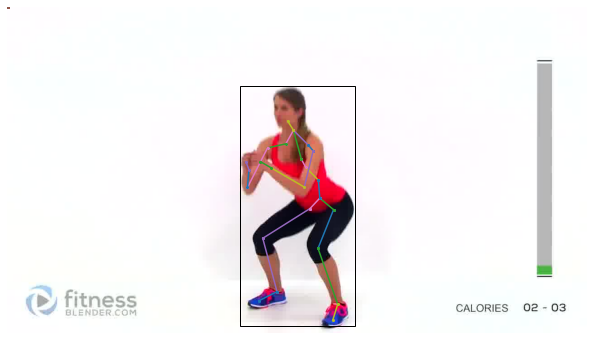

In [ ]:
def get_image2d(im, poses2d, detections, edges, savedir="test/res", 
                filename="test", plot_image=True):
  vis_image = im.numpy()
  vis_edges = model.joint_edges.numpy()
  vis_poses2d = poses2d.numpy()
  vis_detections = detections.numpy()

  fig = plt.figure(figsize=(14, 6))
  image_ax = fig.add_subplot(1, 1, 1)
  image_ax.imshow(vis_image)

  for x, y, w, h in vis_detections[:, :4]:
      image_ax.add_patch(Rectangle((x, y), w, h, fill=False))

  for pose2d in vis_poses2d:
      for i_start, i_end in vis_edges:
          image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
      image_ax.scatter(pose2d[:, 0], pose2d[:, 1], s=2)

  plt.axis("off")
  plt.savefig(f"{savedir}/{filename}")
  if plot_image:
    plt.show();
    pass
  else:
    return

get_image2d(image, poses2d, detections, edges, savedir="test", plot_image=False)

# Inference for video

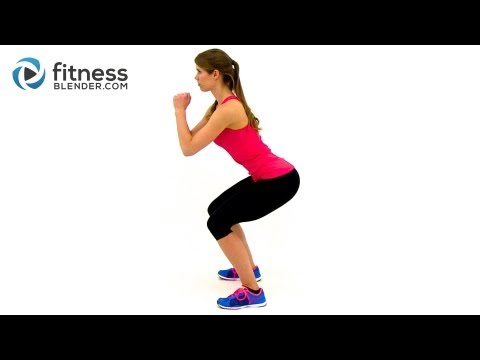

In [ ]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("mGvzVjuY8SY", width=500)
display(video)

In [ ]:
!pip install youtube-dl
!pip install ffmpeg
!youtube-dl https://www.youtube.com/watch?v=mGvzVjuY8SY -f 22 -o video_.mp4
!mkdir test
!ffmpeg -i video_.mp4 -ss 00:00:47 -t 10 -c:v copy test/video-clip.mp4

     |████████████████████████████████| 1.9MB 11.3MB/s 
  Created wheel for ffmpeg: filename=ffmpeg-1.4-cp37-none-any.whl size=6083 sha256=c6a2a860370dcd303df7b0a94ef4abc448a7e6bca0994a55b100b1a59ac3f34d
  Stored in directory: /root/.cache/pip/wheels/b6/68/c3/a05a35f647ba871e5572b9bbfc0b95fd1c6637a2219f959e7a
Successfully built ffmpeg
[youtube] mGvzVjuY8SY: Downloading webpage
[download] Destination: video_.mp4
[download] 100% of 29.63MiB in 00:00
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribi

In [ ]:
# !mkdir test/imgs
# !mkdir test/res
!ffmpeg -i test/video-clip.mp4 -r 5/1 test/imgs/frame%03d.jpg

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
# !rm -r test/imgs/
# !mkdir test/imgs
# !rm -r test/res/
# !mkdir test/res

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Done!
frame001.jpg  frame012.jpg  frame023.jpg  frame034.jpg	frame045.jpg
frame002.jpg  frame013.jpg  frame024.jpg  frame035.jpg	frame046.jpg
frame003.jpg  frame014.jpg  frame025.jpg  frame036.jpg	frame047.jpg
frame004.jpg  frame015.jpg  frame026.jpg  frame037.jpg	frame048.jpg
frame005.jpg  frame016.jpg  frame027.jpg  frame038.jpg	frame049.jpg
frame006.jpg  frame017.jpg  frame028.jpg  frame039.jpg	frame050.jpg
frame007.jpg  frame018.jpg  frame029.jpg  frame040.jpg	frame051.jpg
frame008.jpg  frame019.jpg  frame030.jpg  frame041.jpg	frame052.jpg
frame009.jpg  frame020.jpg  frame031.jpg  frame042.jpg
frame010.jpg  frame021.jpg  frame032.jpg  frame043.jpg
frame011.jpg  frame022.jpg  frame033.jpg  frame044.jpg


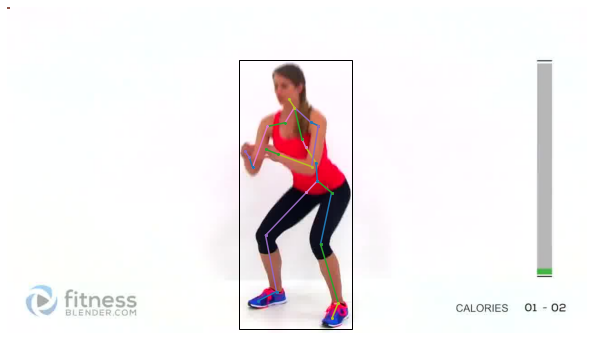

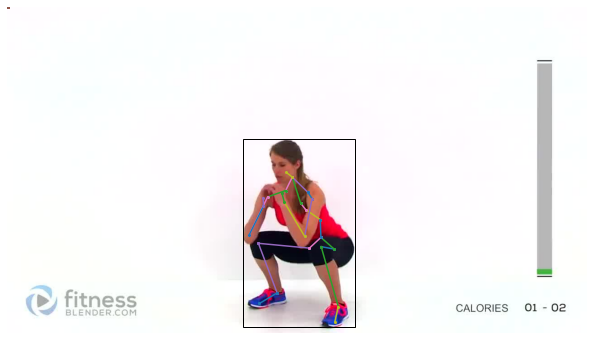

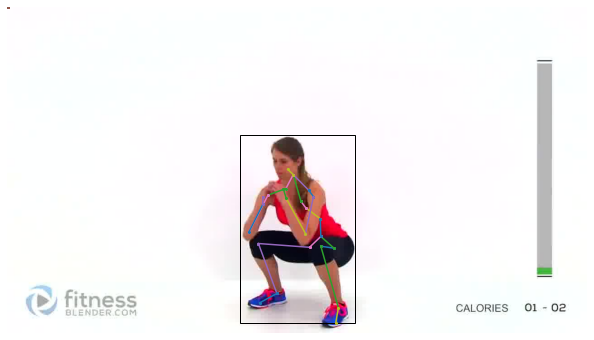

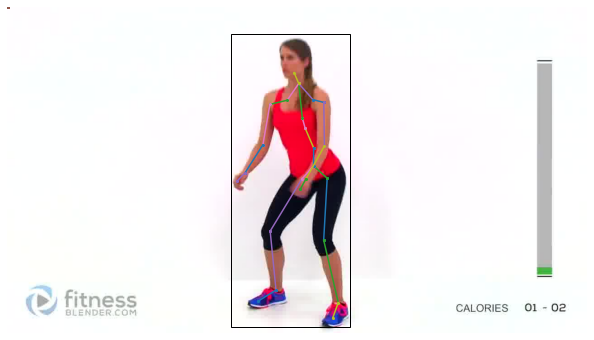

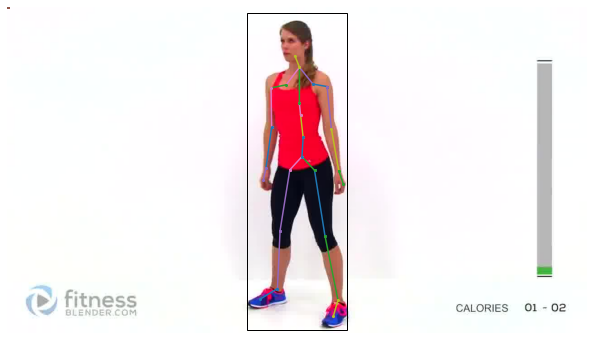

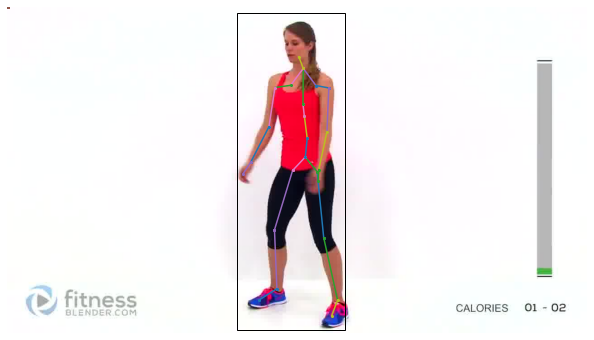

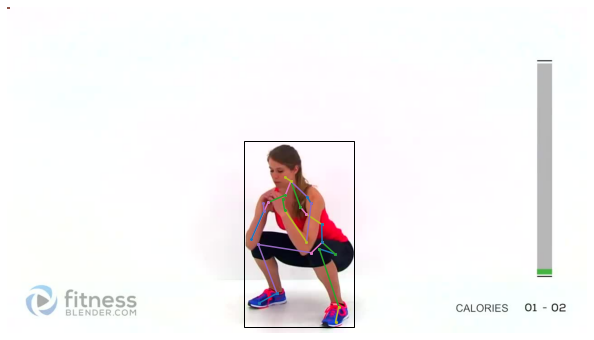

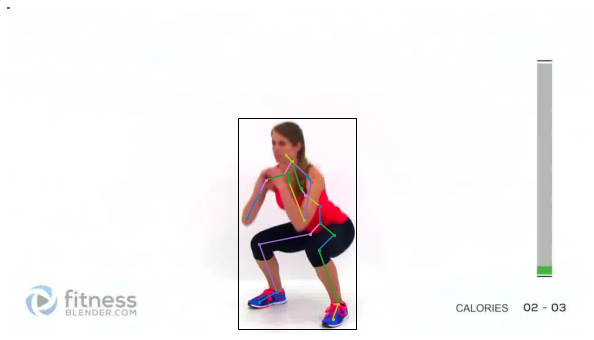

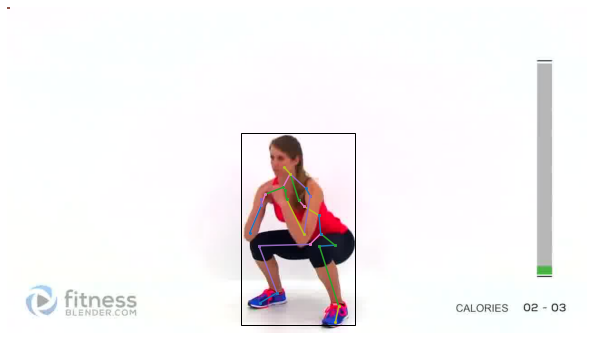

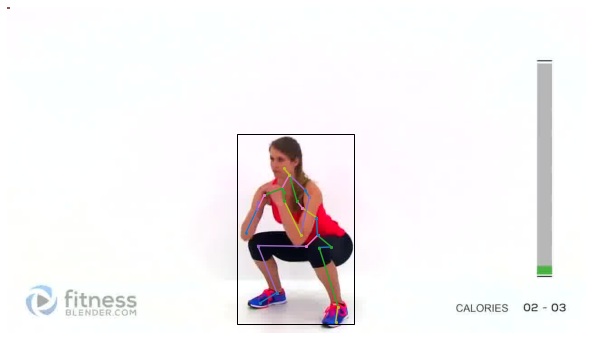

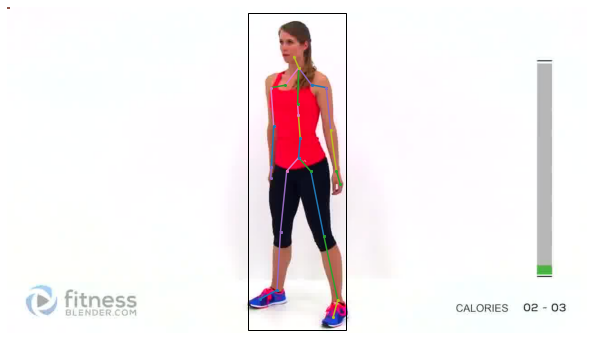

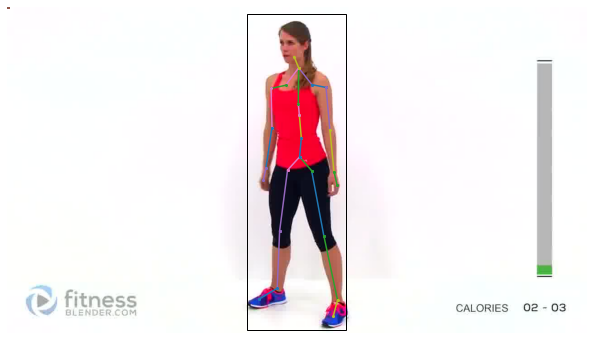

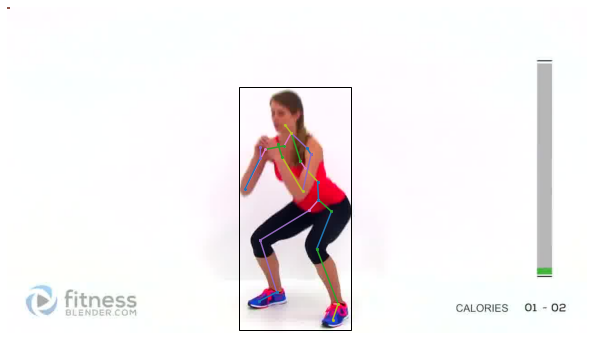

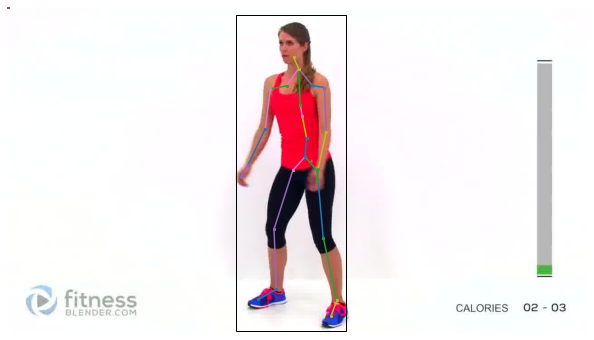

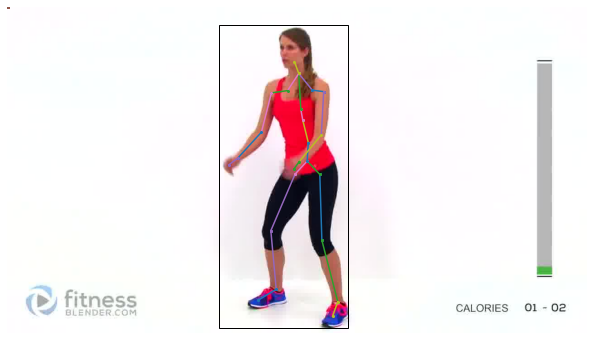

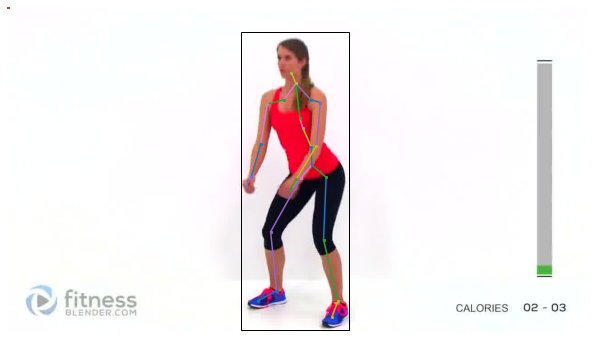

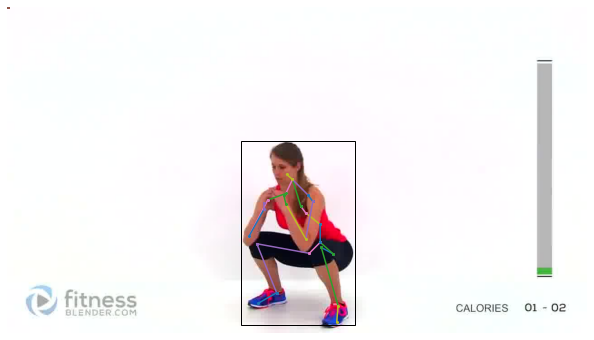

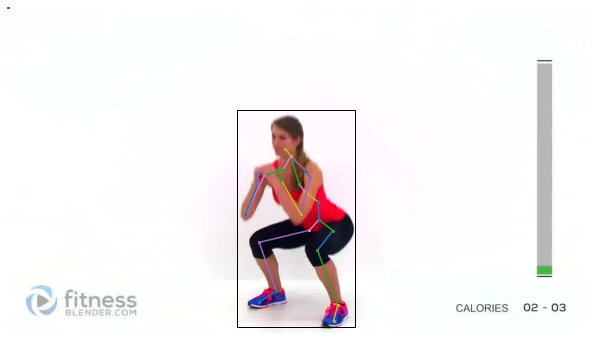

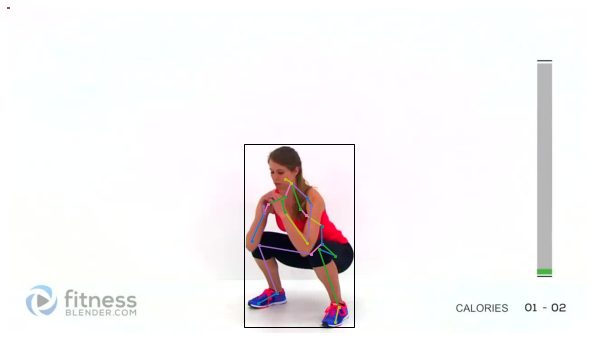

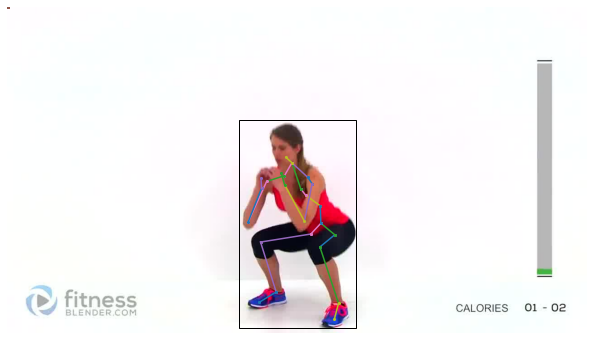

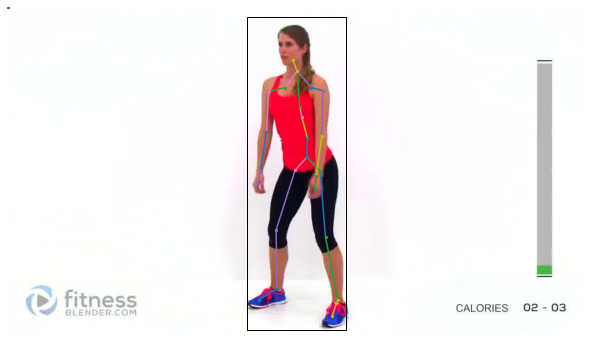

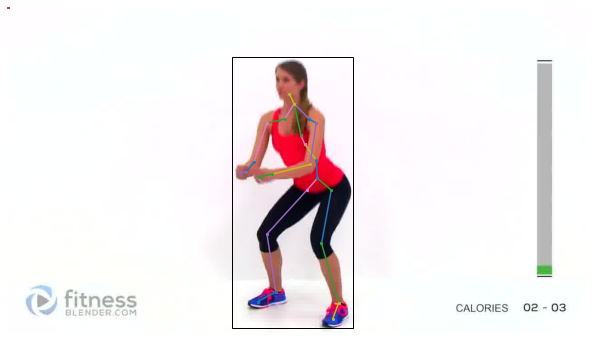

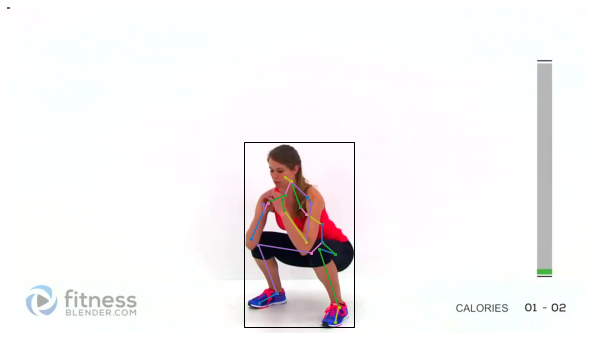

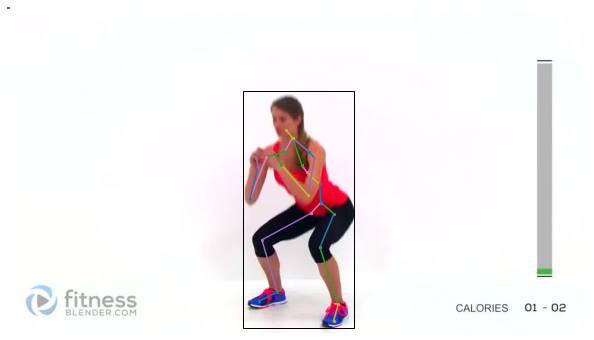

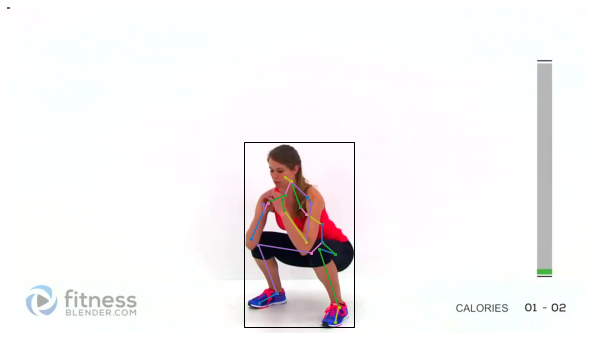

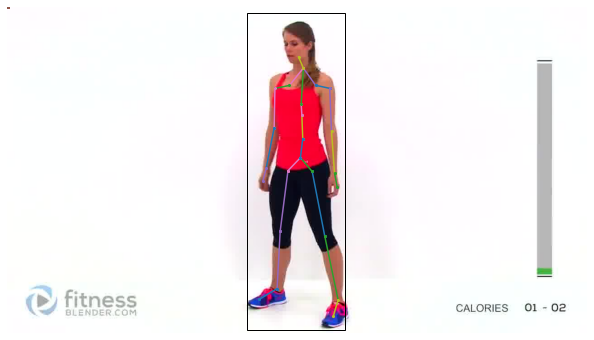

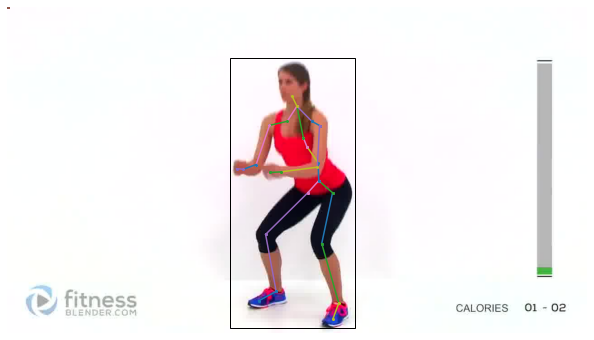

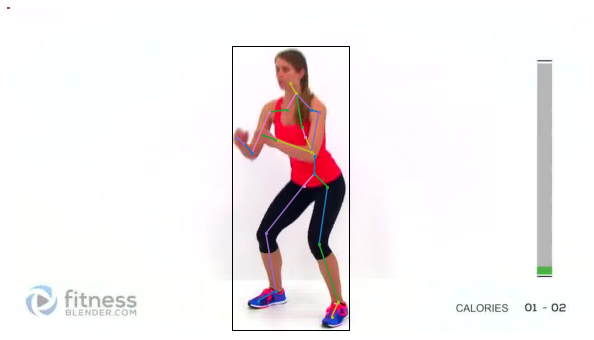

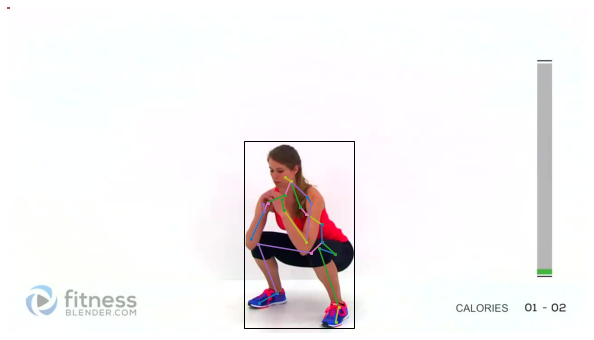

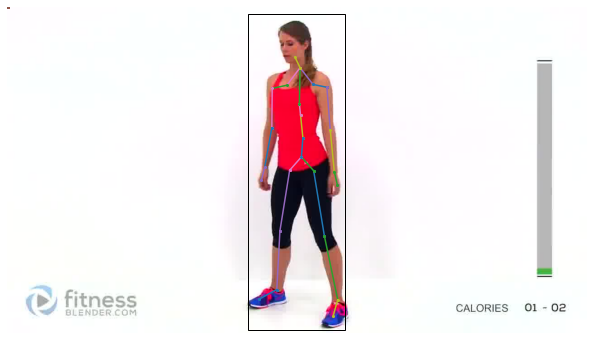

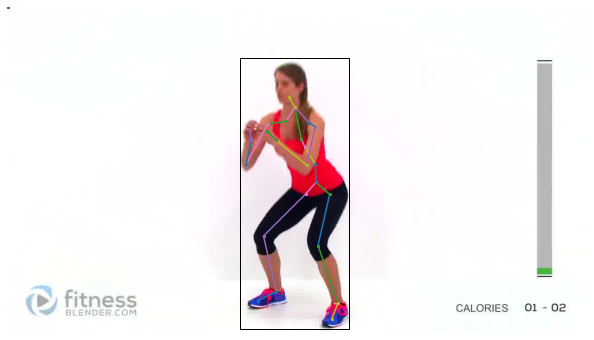

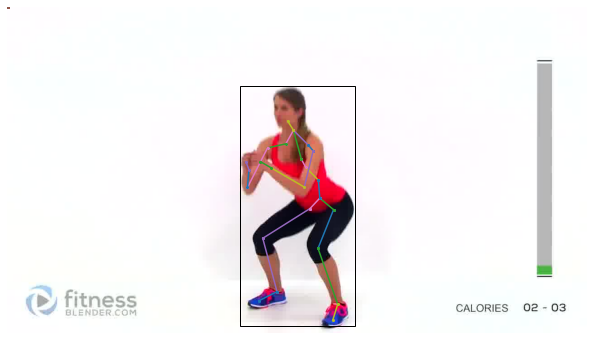

In [ ]:
import os

directory = os.path.join("test", "imgs")
c=0
for filename in os.listdir(directory):
  filename_ = os.path.join("test","imgs",filename)
  image = tf.image.decode_jpeg(tf.io.read_file(filename_))
  detections, poses3d, poses2d = model.predict_single_image(image)
  edges = model.joint_edges.numpy()
  get_image2d(image, poses2d, detections, edges, filename=filename, plot_image=False)
  c +=1

print("Done!")
!ls test/res/

In [ ]:
!ffmpeg -framerate 5 -pattern_type glob -i '/content/test/res/frame*.jpg' \
-c:v libx264 -vf fps=5 -pix_fmt yuv420p out.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib